<a href="https://colab.research.google.com/github/abyaadrafid/BHGD/blob/master/Copy_of_BanglaHandwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jan 14 13:12:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
#import torchsummary
# !pip install torch-lr-finder
# from torch_lr_finder import LRFinder
import copy
import math
import random
from PIL.Image import BICUBIC
import json

In [4]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [0]:
torch.set_num_threads(4)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [0]:
df_train = pd.read_csv('/content/drive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/drive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/drive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
    for parquet_loc in tqdm(parquet_locs):
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
def make_tensordataset_from_npys(npy_locs, ids_file, label_loc=None):
    with open(ids_file) as f:
        ids = json.load(f)
    X = []
    npy_locs = tqdm(npy_locs)
    for npy_loc in npy_locs:
        x = np.load(npy_loc)
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [12]:
ds = make_tensordataset_from_dfs(['/content/drive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/drive/My Drive/kaggle/train.csv')

100%|██████████| 4/4 [01:50<00:00, 27.11s/it]


In [0]:
#ds = make_tensordataset_from_npys(['tr-ds-{}.npy'.format(i) for i in range(1,5)], 'tr-ds-ids.json', 'train.csv')

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


(tensor(22),
 tensor(9),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(14, dtype=torch.uint8),
 100989)

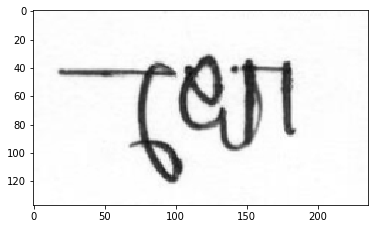

In [13]:
idx = random.randrange(len(ds))
plt.imshow(ds[idx][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[idx][1], ds[idx][2], ds[idx][3], ds[idx][0].max(), ds[idx][0].min(), idx

In [0]:
tr_indices, va_indices = train_test_split(
    list(range(len(ds))), 
    test_size=.1, 
    train_size=.9, 
    random_state=42
)#, stratify=ds.tensors[1])

In [0]:
class TensorWithImageTransforms(Dataset):
    def __init__(self, tensor_dataset, transforms, p=0.0):
        super(TensorWithImageTransforms, self).__init__()
        self.ds = tensor_dataset
        self.tr = transforms
        self.nt = len(self.ds[0])
        self.ln = len(self.ds)
        self.p = p
        
    def __getitem__(self, index):
        img = self.ds[index][0]
        if random.random() > self.p:
            img = self.tr(img)
            if img.max() < 255:
                img *= 255.0
            else:
                img = img.float()
        else:
            img = img.float()
        return (img,) + self.ds[index][1:]
    
    def __len__(self):
        return self.ln

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [0]:
def thresh(t):
    t = t.clone().detach()
    t.mul_(-1)
    nn.functional.threshold_(t, -175, -255)
    t.mul_(-1)
    return t
thresh = transforms.Lambda(thresh)
tfms = transforms.Compose([
    thresh,
    transforms.ToPILImage(mode='L'),
    transforms.RandomAffine(degrees=5.0, translate=(0.20, 0.00), scale=(0.75, 1.0), shear=(-50, 50, -0, 0), resample=BICUBIC, fillcolor=255),
    transforms.ToTensor(),
])
va_tfms = transforms.Compose([
    thresh,
])

In [0]:
tr_ds_tfms = TensorWithImageTransforms(tr_ds, tfms, p=0.0)

In [0]:
va_ds_tfms = TensorWithImageTransforms(va_ds, va_tfms, p=0.0)

In [0]:
idx = random.randrange(len(tr_ds_tfms))

135    শ্ন
Name: component, dtype: object
168    0
Name: component, dtype: object
179    0
Name: component, dtype: object


(tensor(255.), tensor(20.), 110250)

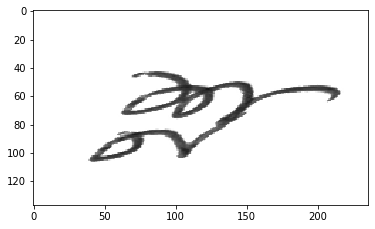

In [21]:
im = tr_ds_tfms[idx][0].permute(1, 2, 0).reshape(137, 236)
plt.imshow(im, cmap='gray', vmin=0., vmax=255.)
g, v, c = map(lambda t: t.item(), tr_ds_tfms[idx][1:])
print(df_class[(df_class['label'] == g) & (df_class['component_type'] == 'grapheme_root')]['component'])
print(df_class[(df_class['label'] == v) & (df_class['component_type'] == 'vowel_diacritic')]['component'])
print(df_class[(df_class['label'] == c) & (df_class['component_type'] == 'consonant_diacritic')]['component'])
im.max(), im.min(), idx

In [0]:
tr_ds = tr_ds_tfms

In [0]:
va_ds = va_ds_tfms

In [24]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(nn.Linear(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

def make_squeeze_predictor(in_size, out_size):
    return nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_size, out_size, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
#         base = models.squeezenet1_0(pretrained=True).features
        # base = models.resnet18(pretrained=True)
        base = models.wide_resnet101_2(pretrained=False)
        base.fc = nn.Identity()
#         base = models.densenet121(pretrained=True)
#         base.classifier = nn.Identity()
        self.base = base
        feature_size = 2048
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 4)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 3)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 3)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(self.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
#             conv1.weight.data = torch.sum(self.base.features.conv0.weight.data, dim=1, keepdim=True)
#             self.base.features.conv0 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks, init_weight=None):
        super(MultiTaskLoss, self).__init__()
        self.n = num_tasks
        if init_weight is None:
            self.w = nn.Parameter(torch.zeros(self.n))
        else:
            self.w = nn.Parameter(torch.tensor(init_weight))
            
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, losses):
        return torch.sum(torch.exp(-2.0 * self.w) * losses) + torch.sum(self.w)

In [0]:
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks, init_weight=None, collapse=True):
        super(MultiTaskLoss, self).__init__()
        self.n = num_tasks
        if init_weight is None:
            self.w = nn.Parameter(torch.ones(self.n))
        else:
            self.w = nn.Parameter(torch.tensor(init_weight))
        self.requires_grad = False
        self.collapse = collapse
        if not collapse:
            self.w.data = self.w.data.reshape(-1, 1)

    def forward(self, losses):
        if not self.collapse:
            return torch.sum(losses * self.w, dim=0)
        else:
            return torch.sum(losses * self.w)# - torch.sum(torch.sum(torch.log(self.w)))

In [0]:
def train_multi_task_batch(model, optimizer, criterions, mtl_criterion, device, batch):
    img, g, v, c = batch
    img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
    img = img / 255.0
    g_criterion, v_criterion, c_criterion = criterions
    optimizer.zero_grad()
    g_pred, v_pred, c_pred = model(img)
    g_loss = g_criterion(g_pred, g)
    v_loss = v_criterion(v_pred, v)
    c_loss = c_criterion(c_pred, c)
    loss = mtl_criterion(torch.stack((g_loss, v_loss, c_loss)))
    loss.backward()
    optimizer.step()
    return loss.item(), g_loss.item(), v_loss.item(), c_loss.item()

In [0]:
def validate_multi_task_batch(model, criterions, mtl_criterion, device, batch, collapse=True):
    with torch.no_grad():
        img, g, v, c = batch
        img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
        img = img / 255.0
        g_pred, v_pred, c_pred = model(img)
        g_criterion, v_criterion, c_criterion = criterions
        g_loss = g_criterion(g_pred, g)
        v_loss = v_criterion(v_pred, v)
        c_loss = c_criterion(c_pred, c)
        loss = mtl_criterion(torch.stack((g_loss, v_loss, c_loss)))
        if not collapse:
            losses = (loss.tolist(), g_loss.tolist(), v_loss.tolist(), c_loss.tolist())
        else:
            losses = (loss.item(), g_loss.item(), v_loss.item(), c_loss.item())
        preds = (g_pred.argmax(1).tolist(), v_pred.argmax(1).tolist(), c_pred.argmax(1).tolist())
        trues = (g.tolist(), v.tolist(), c.tolist())
        return losses, preds, trues

In [0]:
def get_top_losses(model, criterions, mtl_criterion, device, dl):
    model.eval()
    all_losses = []
    g_losses = []
    v_losses = []
    c_losses = []
    g_preds = []
    v_preds = []
    c_preds = []
    count = 0
    for batch in dl:
        count += 1
        losses, preds, trues = validate_multi_task_batch(model, criterions, mtl_criterion, device, batch, collapse=False)
        all_losses.extend(losses[0])
        g_losses.extend(losses[1])
        v_losses.extend(losses[2])
        c_losses.extend(losses[3])
        g_preds.extend(preds[0])
        v_preds.extend(preds[1])
        c_preds.extend(preds[2])
    ret = list(zip(range(len(all_losses)), all_losses, g_losses, v_losses, c_losses, g_preds, v_preds, c_preds))
    ret = sorted(ret, key=lambda t: -t[1])
    return ret

In [0]:
# LRFinder
def lr_finder(model, optimizer, criterions, mtl_criterion, device, dl, num_iter=10, start_lr=1e-4, end_lr=1.0):
    model_state =  copy.deepcopy(model.state_dict())
    optim_state =  copy.deepcopy(optimizer.state_dict())
    mtl_criterion_state = copy.deepcopy(mtl_criterion.state_dict())
    for param in optimizer.param_groups:
        param['lr'] = start_lr
    gamma = (end_lr / start_lr) ** (1 / num_iter)
    print(gamma, start_lr, end_lr)
    lrf_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    count = 0
    lrf_losses = []
    lrs = []
    min_loss = math.inf
    done = False
    while not done:
        batches = dl
        batches = notebook.tqdm(tr_dl)
        for batch in batches:
            count += 1
            losses = train_multi_task_batch(model, optimizer, criterions, mtl_criterion, device, batch)
            print(losses)
            min_loss = min(min_loss, losses[0])
            lrf_losses.append(losses)
            lrf_sched.step()
            lrs.append([pg['lr'] for pg in optimizer.param_groups])
            if num_iter == count:# or losses[0] /10.0 > min_loss:
                done = True
                print(min_loss, losses[0] / 10.0)
                break
    model.load_state_dict(model_state)
    optimizer.load_state_dict(optim_state)
    mtl_criterion.load_state_dict(mtl_criterion_state)
    return lrf_losses, lrs

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [34]:
model.convert_to_grayscale()
model.load_state_dict(torch.load('/content/drive/My Drive/model-wresnet.pth', map_location=device))

<All keys matched successfully>

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=64, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
va_dl = DataLoader(va_ds, batch_size=64, num_workers=4, pin_memory=True)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [0]:
gloss = LabelSmoothingLoss(168,smoothing=0.1)

In [0]:
criterions = (gloss, criterion, criterion)

In [0]:
mtl_criterion = MultiTaskLoss(3, [1.,1.,1.]).to(device)
mtl_criterion.w.requires_grad = False

In [0]:
# optimizer = optim.Adam([{'params': model.parameters(), 'lr': 3e-4}, {'params': mtl_criterion.parameters(), 'lr': 3e-4}])
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [0]:
tr_losses = []
va_losses = []
va_scores = []
mtl_weights = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
num_epochs = 4
steps_per_epoch = len(tr_dl)

1.5938152741777998 1.313816245529199 0.14120987527964177 0.13878915490973054
(1.527448708084738, 1.2481573911229515, 0.1572440926483862, 0.12204722285413058)
(0.891347689752215, 0.8478599954980326, 0.9402191894345382, 0.9294515785782566)
[[3895  174    2    6   87   21   19   42    1    1    0]
 [  44 3595    0    1    1    2    1    0    0   18    0]
 [  27    4 2517    2    0    0    3   23    0    1    0]
 [   4  104    0 1455    1    0    0    1    0    1   13]
 [  78    3    0    0 1778    5   11    6    0    0    0]
 [  14    6    0    0   17  454   31    0    0    0    0]
 [   9    2    0    0    5    1  431    0    0    0    0]
 [   2    1    3    1    0    0    0 2804    0   48    0]
 [   0    0    1    0    0    0    0   37  288    5    2]
 [   0   10    0    0    0    0    0   18    1 1584    5]
 [   0    1    0    0    0    0    0    4    0   15  337]]
[[12321     5    81     0    65    82     1]
 [   28   641    22     0     0     2     0]
 [  148     4  2147     0     0  

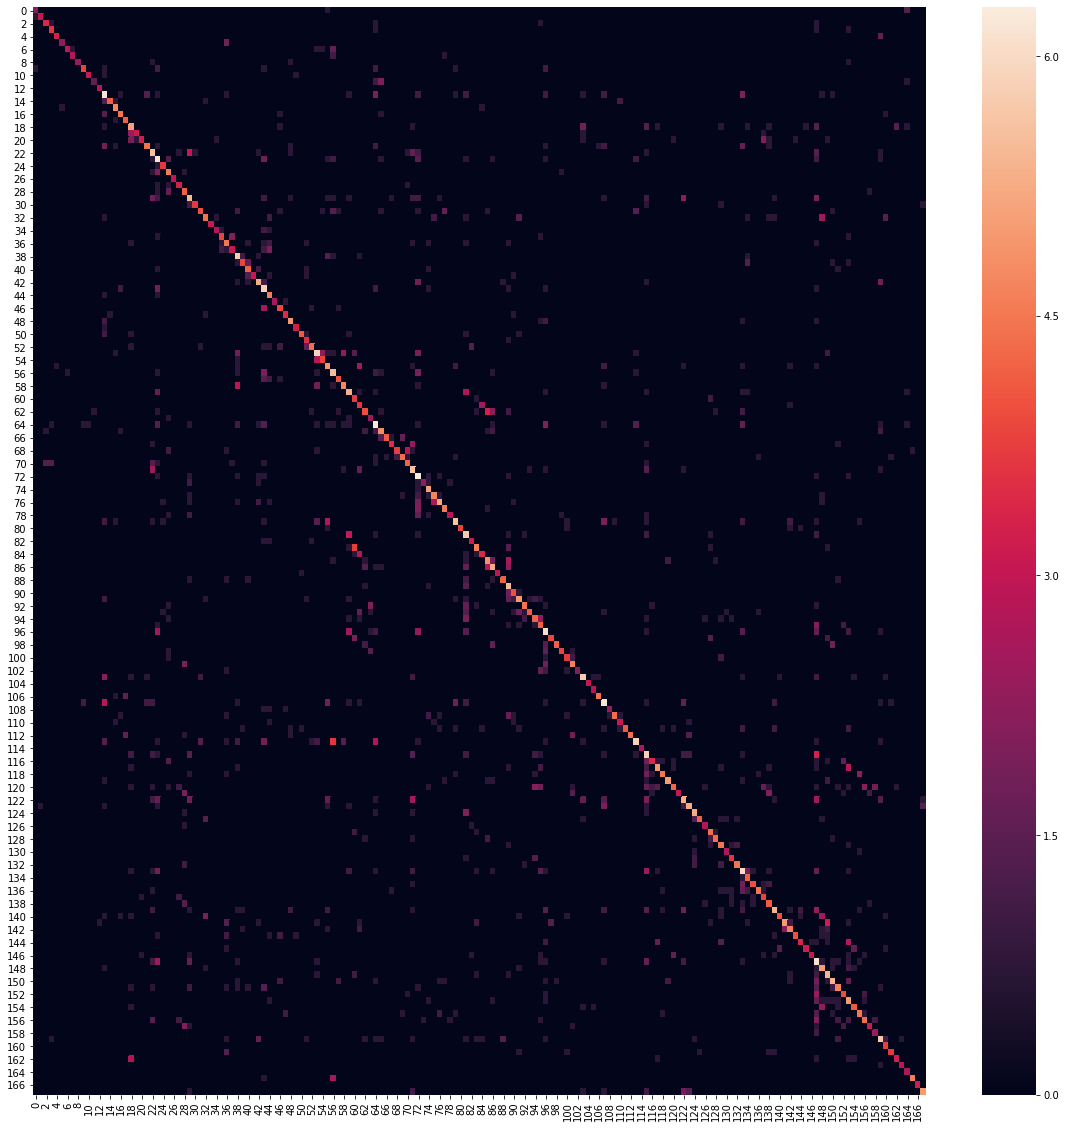

In [0]:
from tqdm import tqdm_notebook as tqdm
epochs = range(num_epochs)
epochs = tqdm(range(num_epochs))
for epoch in epochs:
    model.train()
    count = 0
    batches = tr_dl
    batches = tqdm(tr_dl)
    for batch in batches:
        losses = train_multi_task_batch(model, optimizer, criterions, mtl_criterion, device, batch)
        # batches.set_description("{:0.4f} {:0.4f} {:0.4f} {:0.4f}".format(*losses))
#         scheduler.step()
        tr_losses.append(losses)
        mtl_weights.append(mtl_criterion.w.tolist())
    print(mean([t[0] for t in tr_losses[-steps_per_epoch:]]), 
          mean([t[1] for t in tr_losses[-steps_per_epoch:]]), 
          mean([t[2] for t in tr_losses[-steps_per_epoch:]]), 
          mean([t[3] for t in tr_losses[-steps_per_epoch:]]))
    
    model.eval()
    va_batch_losses = []
    
    va_g_preds = []
    va_v_preds = []
    va_c_preds = []
    
    va_g_trues = []
    va_v_trues = []
    va_c_trues = []
    batches = va_dl
    # batches = tqdm(va_dl)
    for batch in batches:
        losses, preds, trues = validate_multi_task_batch(model, criterions, mtl_criterion, device, batch)
        va_batch_losses.append(losses)

        g_pred, v_pred, c_pred = preds
        g_true, v_true, c_true = trues

        va_g_trues.extend(g_true)
        va_v_trues.extend(v_true)
        va_c_trues.extend(c_true)

        va_g_preds.extend(g_pred)
        va_v_preds.extend(v_pred)
        va_c_preds.extend(c_pred)

    avg_loss = mean([t[0] for t in va_batch_losses])
    avg_g_loss = mean([t[1] for t in va_batch_losses])
    avg_v_loss = mean([t[2] for t in va_batch_losses])
    avg_c_loss = mean([t[3] for t in va_batch_losses])
    va_losses.append((avg_loss, avg_g_loss, avg_v_loss, avg_c_loss))
    g_rec = recall_score(va_g_trues, va_g_preds, average='macro')
    v_rec = recall_score(va_v_trues, va_v_preds, average='macro')
    c_rec = recall_score(va_c_trues, va_c_preds, average='macro')
    score = 0.5 * g_rec + 0.25 * v_rec + 0.25 * c_rec
    va_scores.append((score, g_rec, v_rec, c_rec))
    print(va_losses[-1])
    print(va_scores[-1])
    print(confusion_matrix(va_v_trues, va_v_preds))
    print(confusion_matrix(va_c_trues, va_c_preds))
    torch.save(model.state_dict(),'/content/drive/My Drive/model-wresnet.pth')
    plt.figure(figsize = (20, 20))
    sn.heatmap(np.log1p(confusion_matrix(va_g_trues, va_g_preds)))
    plt.show()

In [0]:
 !nvidia-smi

Sun Jan 12 21:21:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    36W / 250W |  14495MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

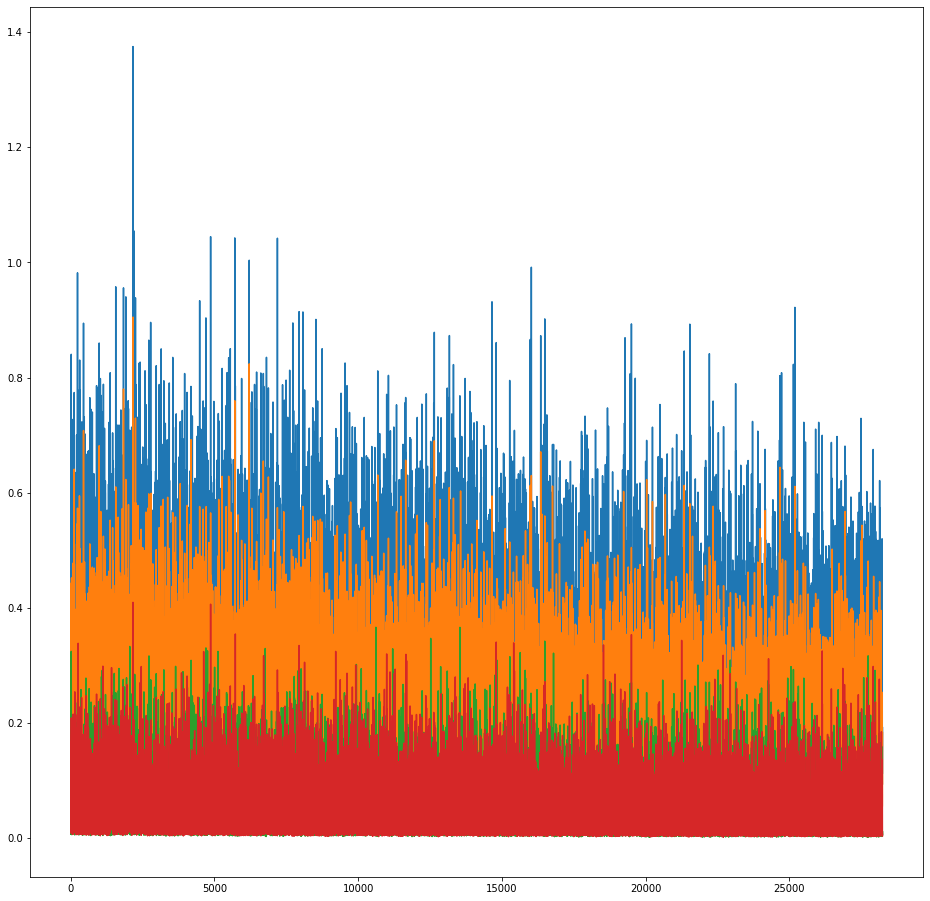

In [0]:
 plt.figure(figsize = (16, 16))
 plt.plot([t for t in tr_losses])

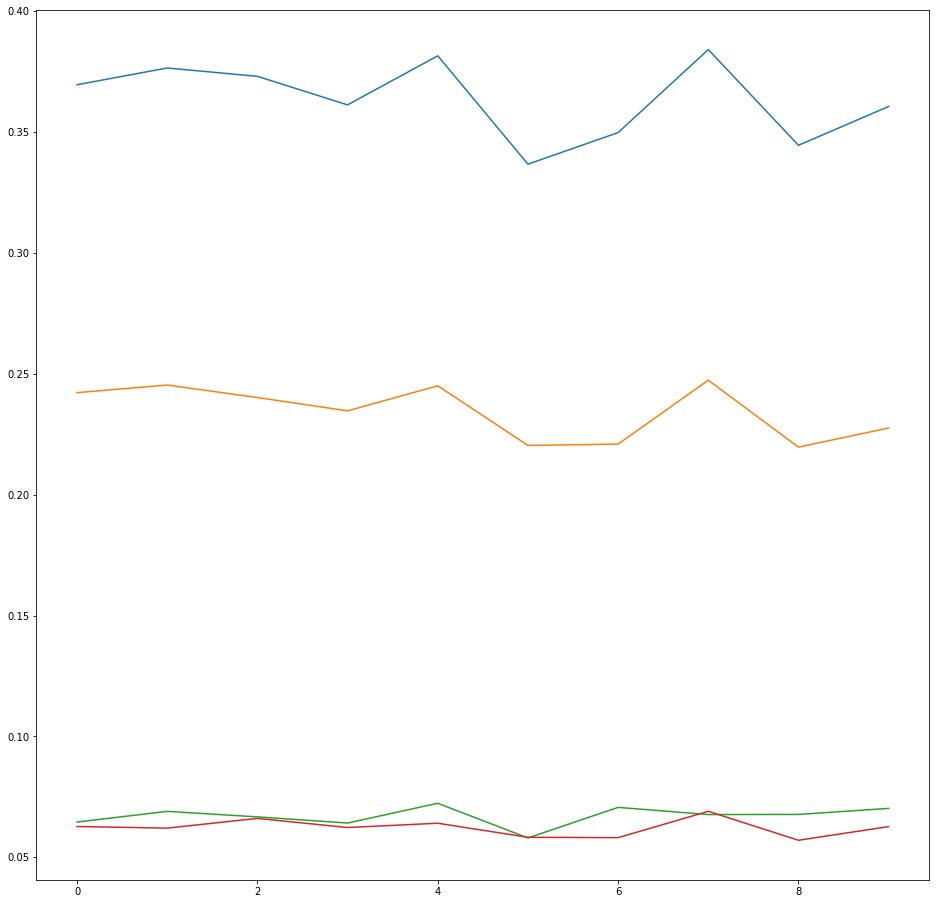

In [0]:
 plt.figure(figsize = (16, 16))
 plt.plot([t for t in va_losses])

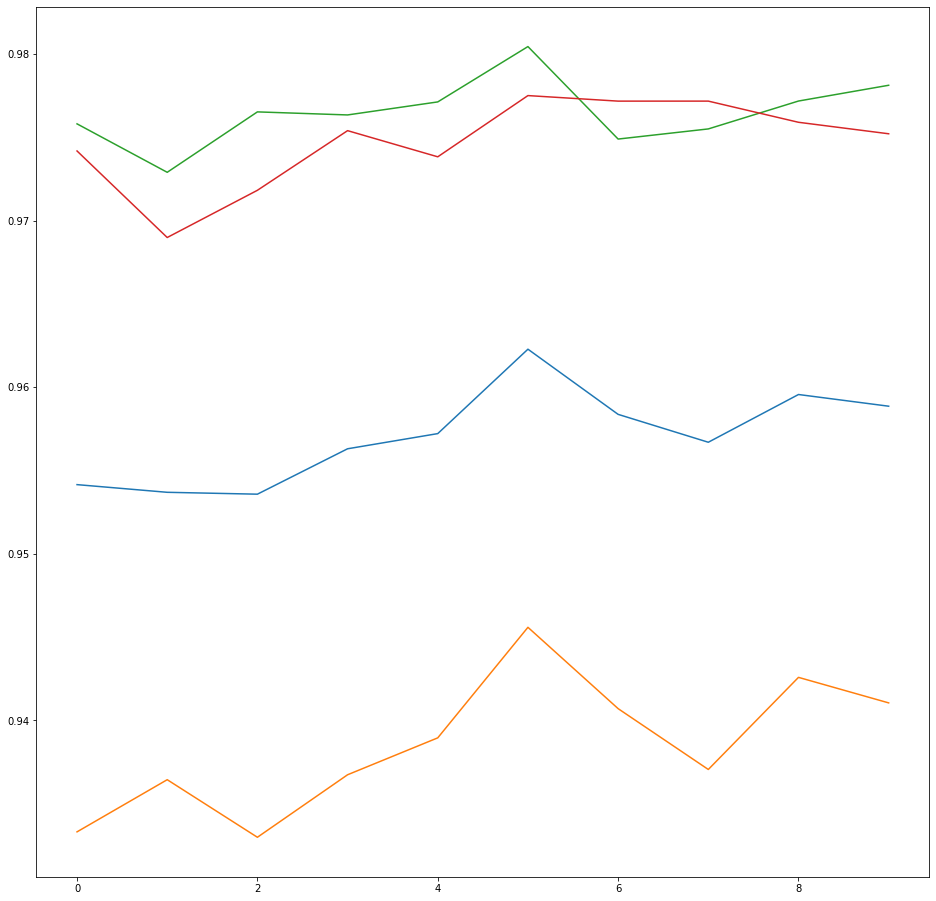

In [0]:
 plt.figure(figsize = (16, 16))
 plt.plot([t for t in va_scores])

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/wideresnet-gvc.pth')
torch.save(optimizer.state_dict(), 'drive/My Drive/wideresnetoptim-gvc.pth')

In [0]:
plt.figure(figsize = (40, 40))
sn.heatmap(np.log1p(confusion_matrix(va_g_trues, va_g_preds)))
plt.show()

In [0]:
criterion = nn.CrossEntropyLoss(reduction='none')
criterions = (criterion, criterion, criterion)
mtl_criterion = MultiTaskLoss(3, [1.,1.,1.], collapse=False).to(device)
mtl_criterion.w.requires_grad = False
index_loss_preds = get_top_losses(model, criterions, mtl_criterion, device, va_dl)

In [0]:
count = 0
for i in range(len(va_ds)):
    idx = i
    idx, loss, g_loss, v_loss, c_loss, g_pred, v_pred, c_pred = index_loss_preds[idx]
    im = va_ds[idx][0].permute(1, 2, 0).reshape(137, 236)
    g, v, c = map(lambda t: t.item(), va_ds[idx][1:])
    if g != g_pred or v!= v_pred or c!= c_pred:
        count += 1
        plt.imshow(im, cmap='gray', vmin=0., vmax=255.)
        plt.show()
        print(df_class[(df_class['label'] == g) & (df_class['component_type'] == 'grapheme_root')]['component'])
        print(df_class[(df_class['label'] == v) & (df_class['component_type'] == 'vowel_diacritic')]['component'])
        print(df_class[(df_class['label'] == c) & (df_class['component_type'] == 'consonant_diacritic')]['component'])
        print(df_class[(df_class['label'] == g_pred) & (df_class['component_type'] == 'grapheme_root')]['component'])
        print(df_class[(df_class['label'] == v_pred) & (df_class['component_type'] == 'vowel_diacritic')]['component'])
        print(df_class[(df_class['label'] == c_pred) & (df_class['component_type'] == 'consonant_diacritic')]['component'])
        print(i, idx, loss, g_loss, v_loss, c_loss)
        if count == 100:
            break

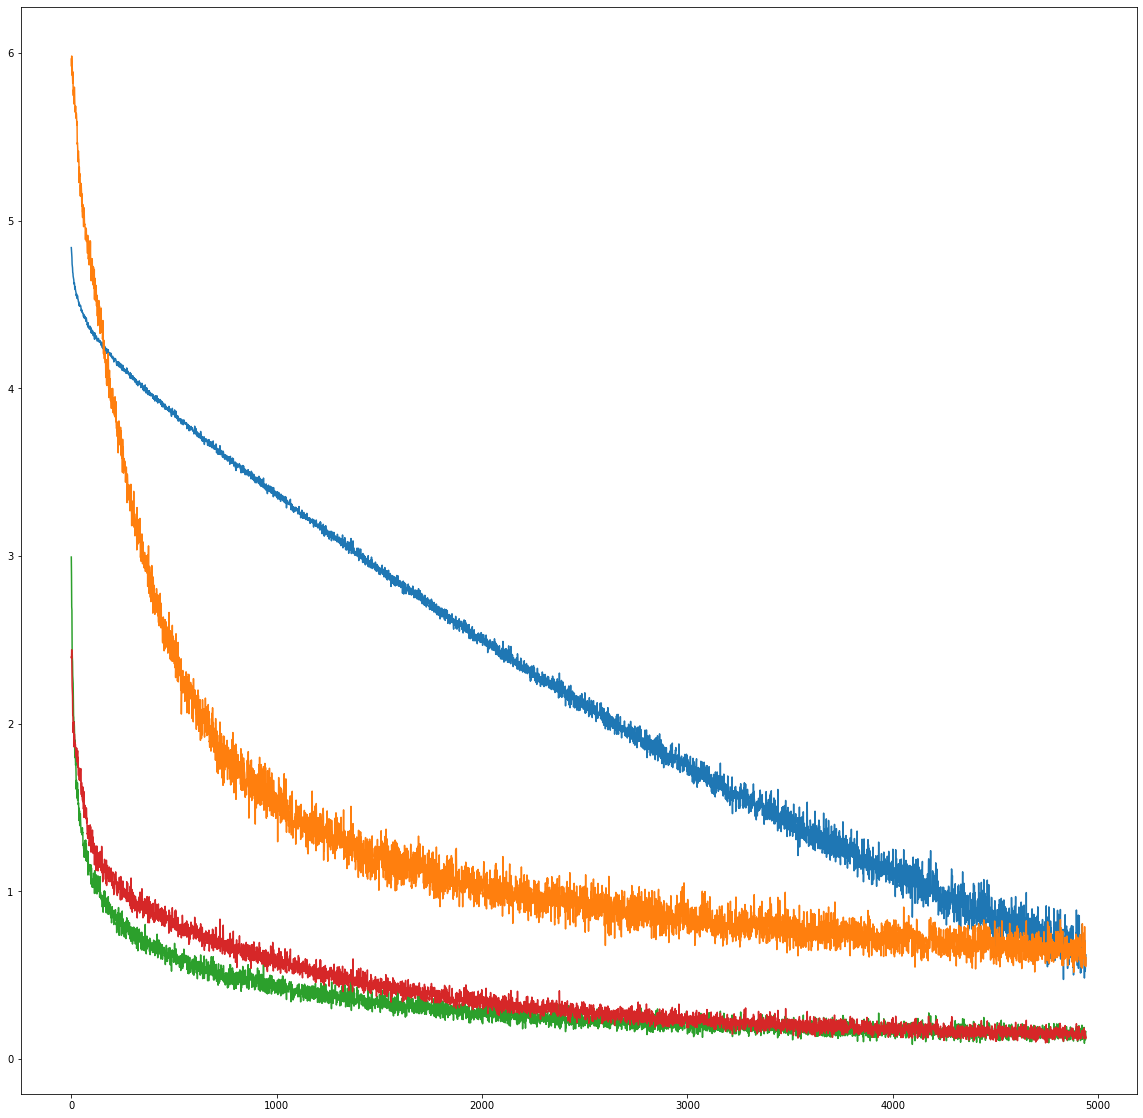

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in tr_losses])

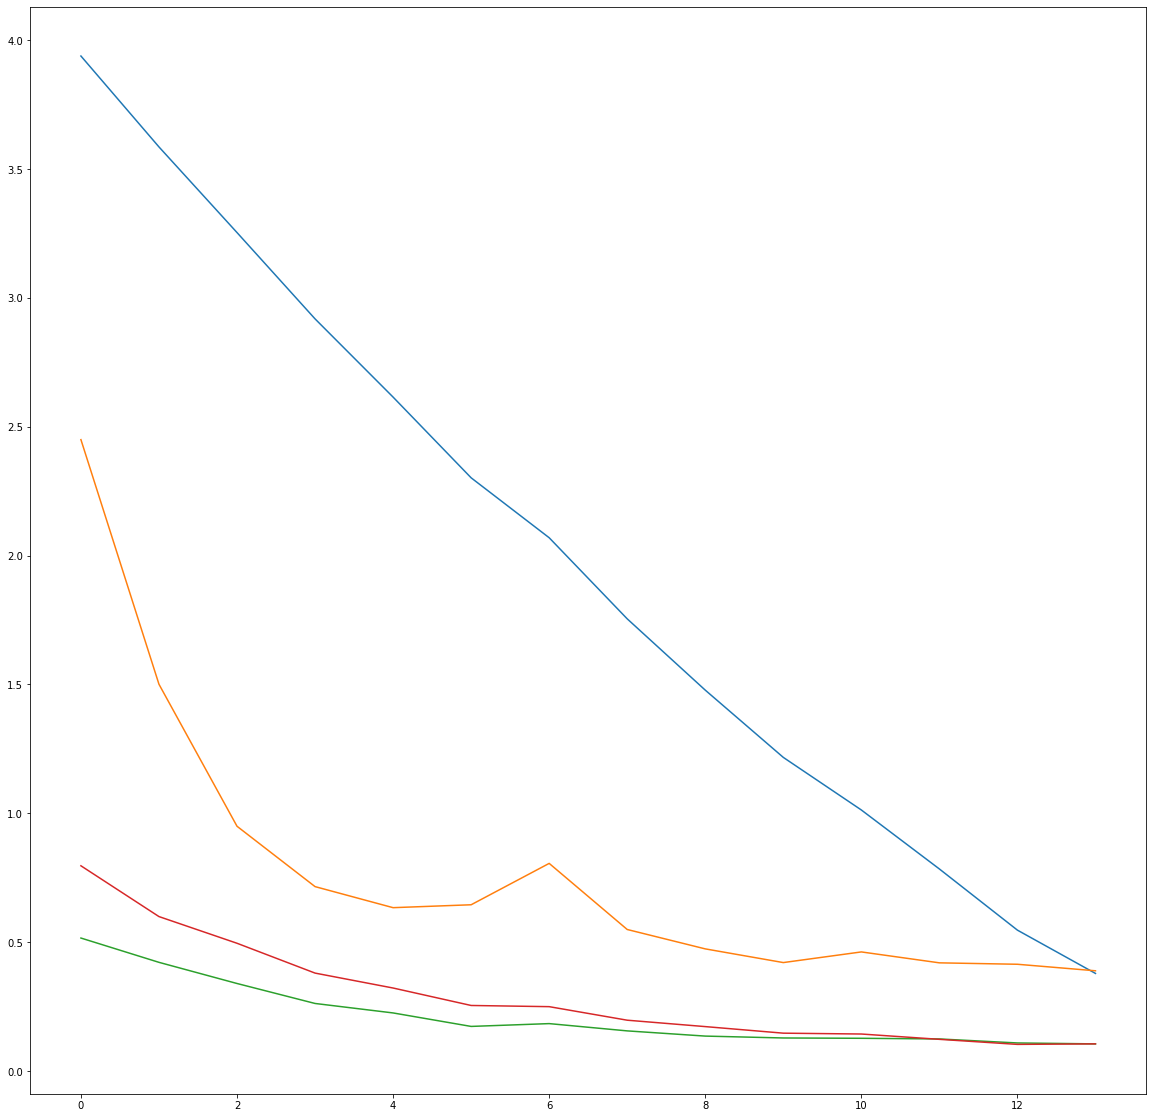

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in va_losses])

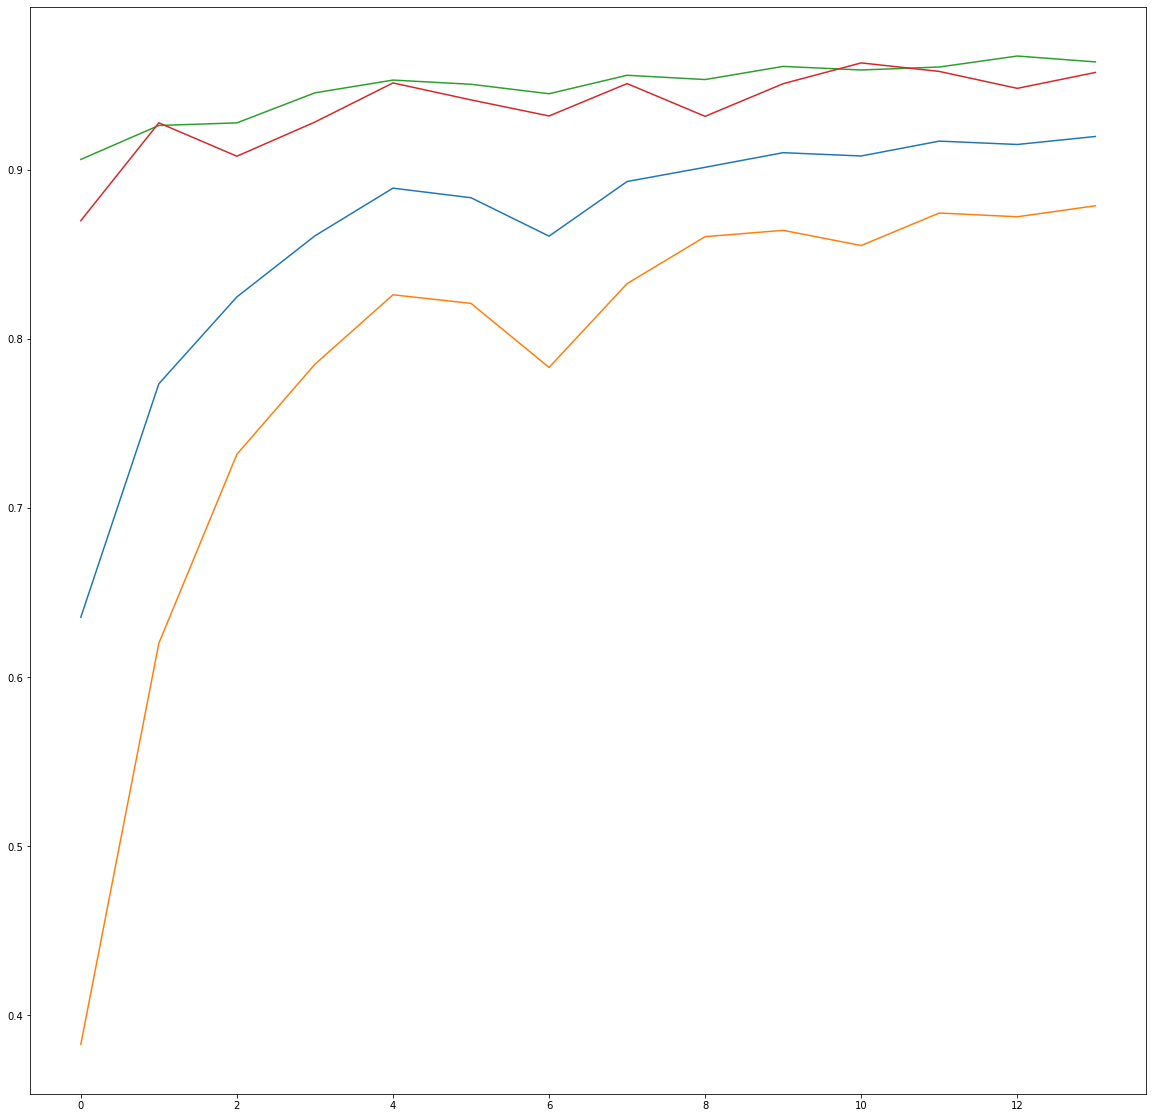

In [0]:
plt.figure(figsize = (20, 20))
plt.plot([t for t in va_scores])

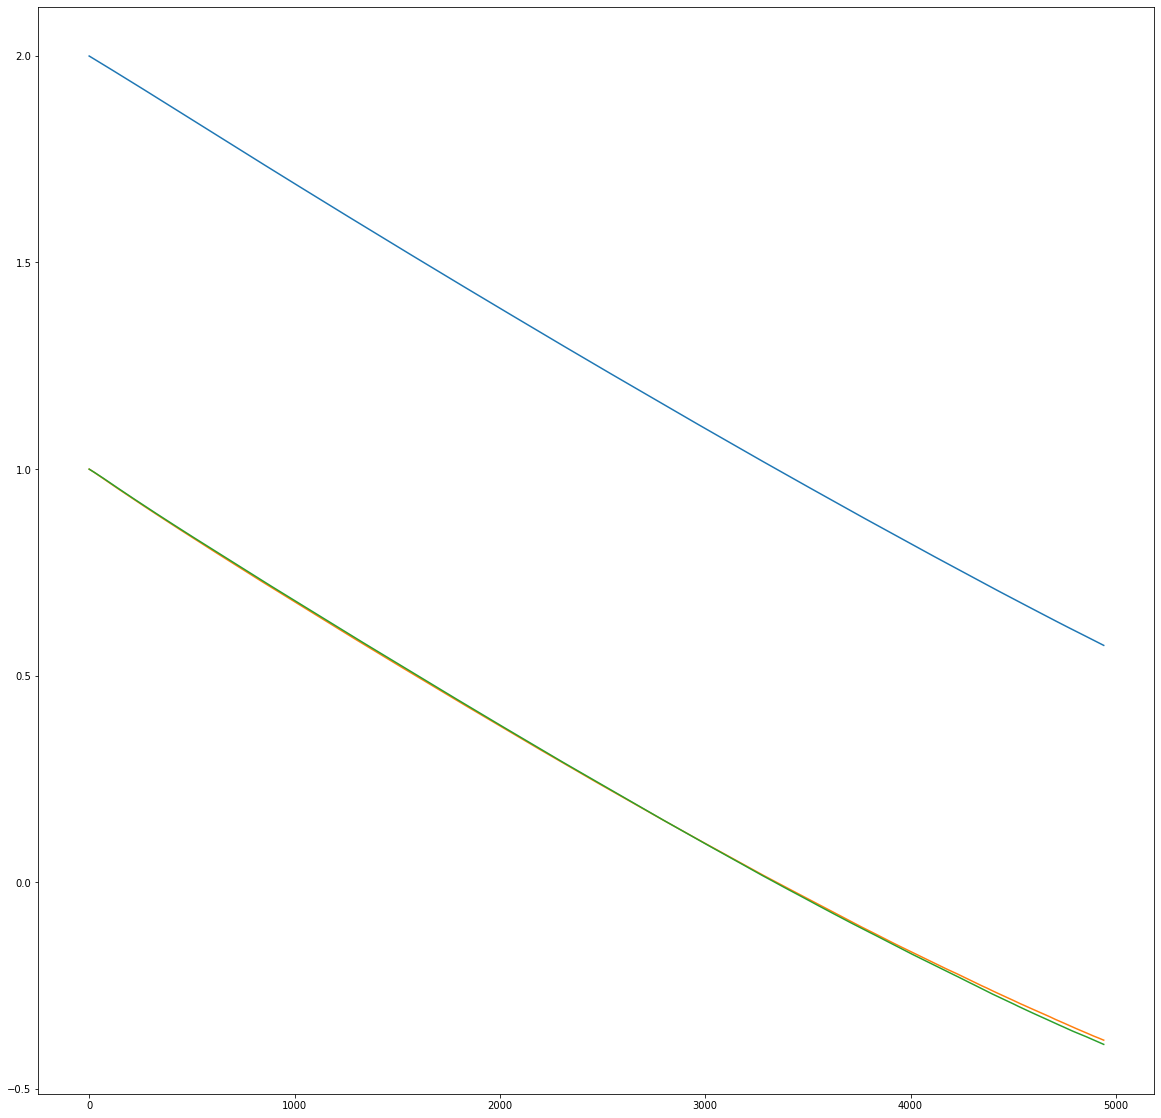

In [0]:
plt.figure(figsize = (20, 20))
plt.plot([t for t in mtl_weights])

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/model-gvctwu.pth')
torch.save(optimizer.state_dict(), 'drive/My Drive/optim-gvctwu.pth')

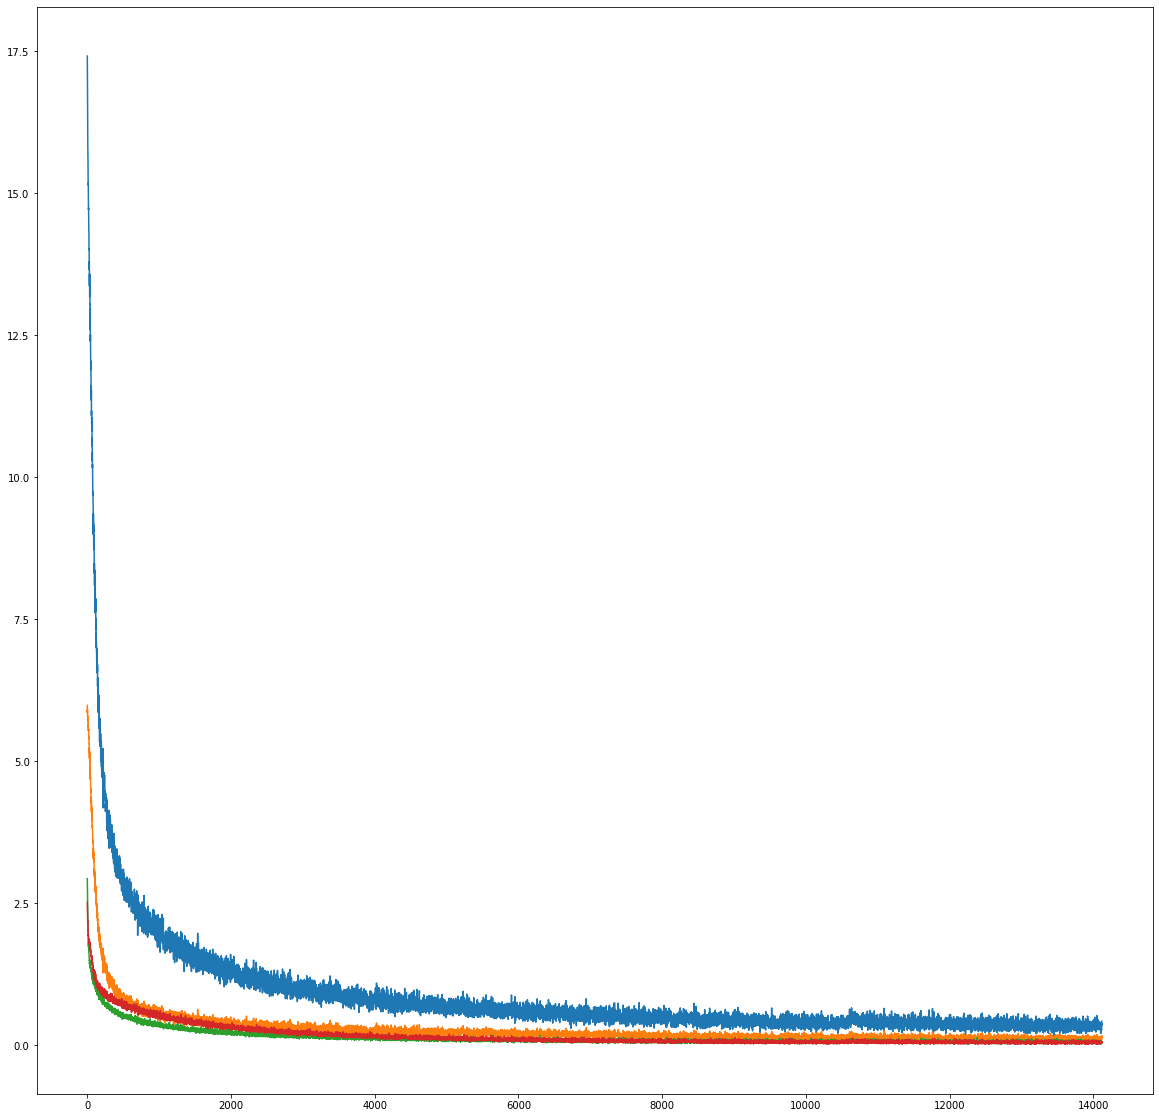

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in tr_losses])

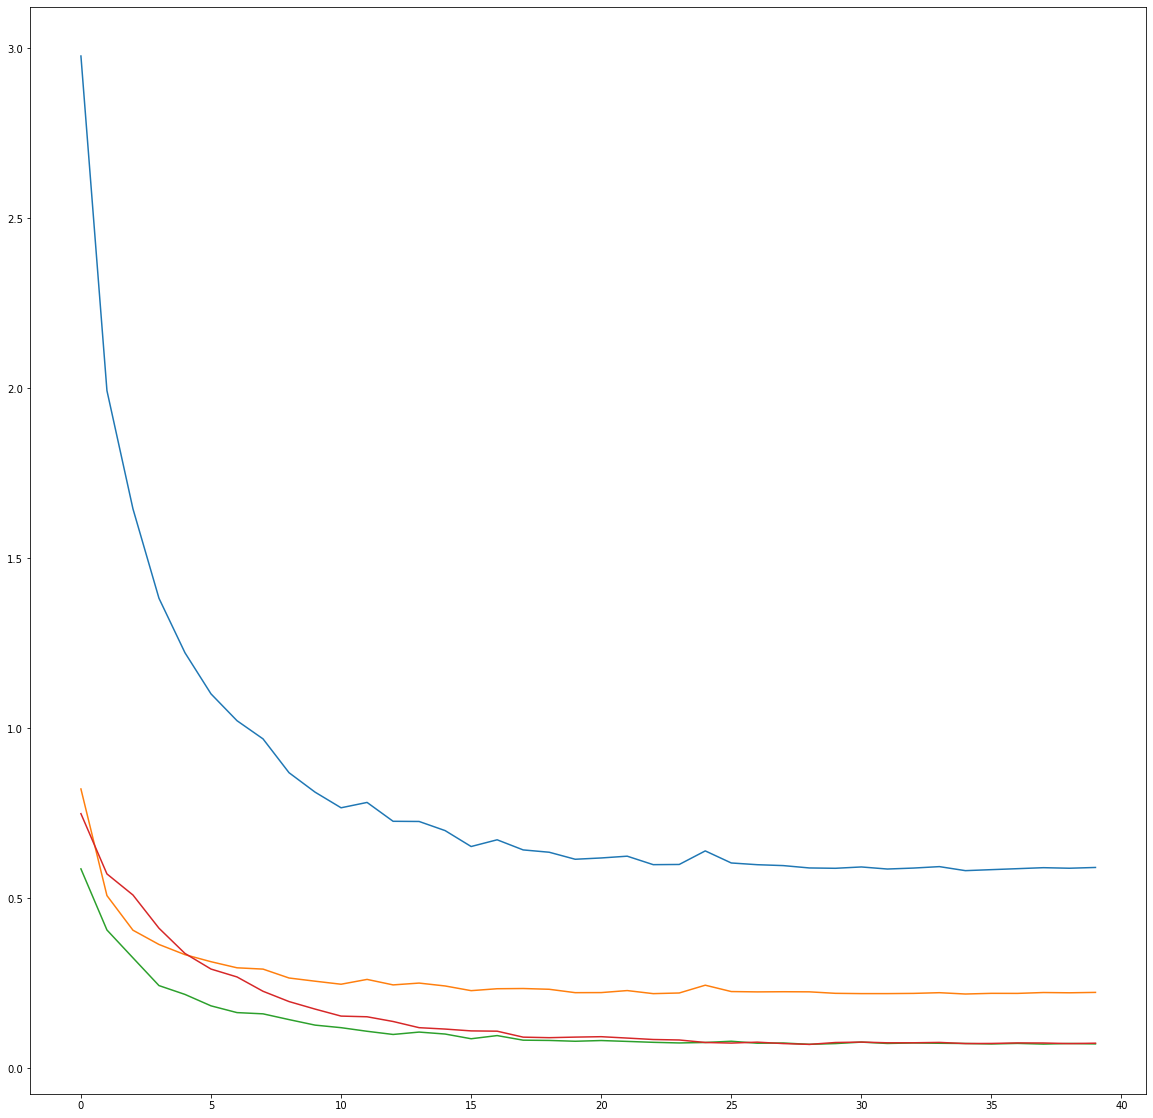

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in va_losses])

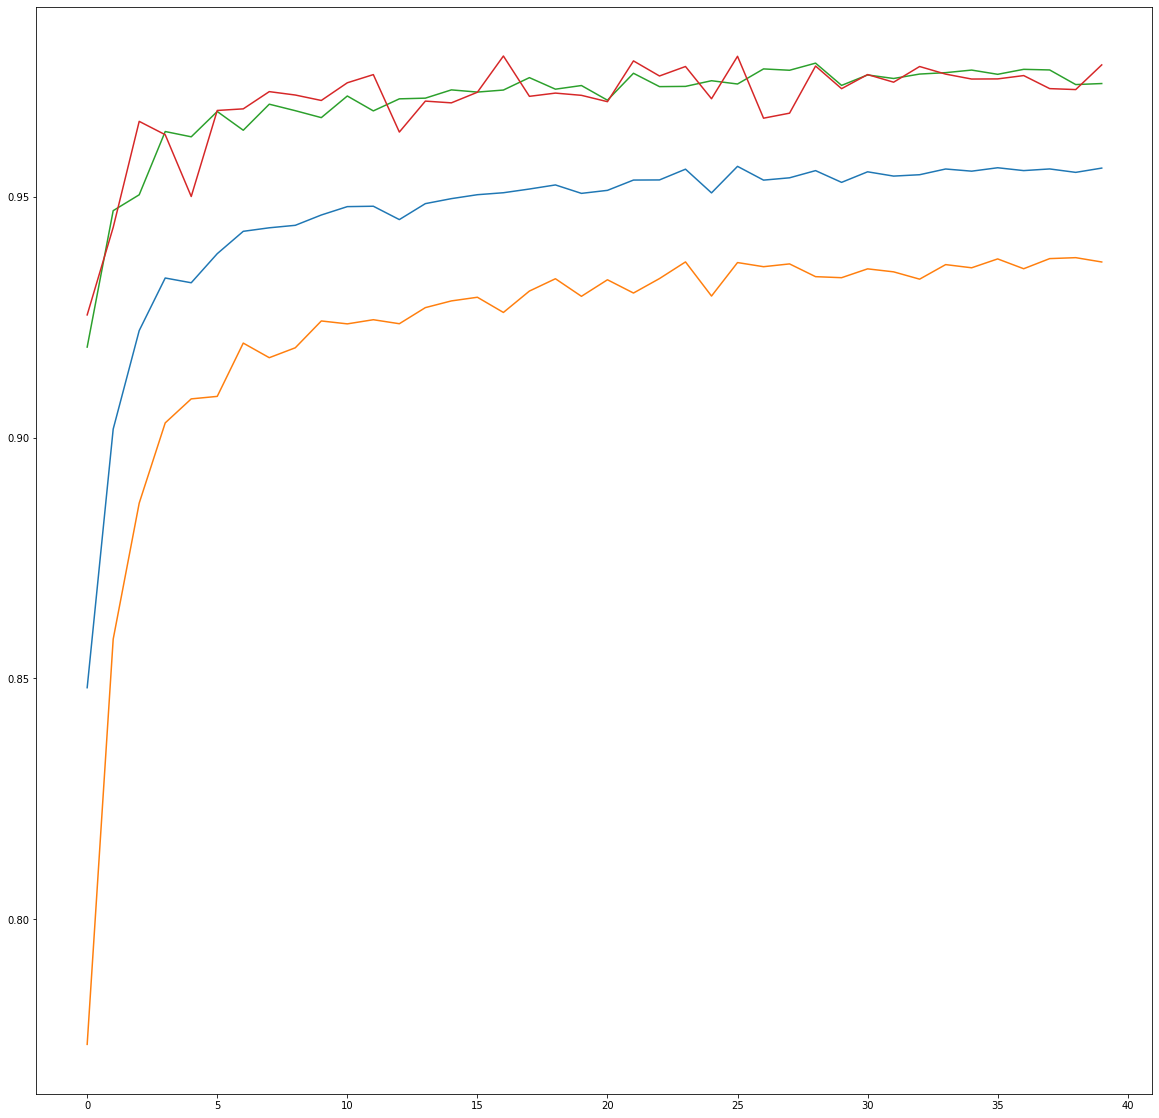

In [0]:
plt.figure(figsize = (20, 20))
plt.plot([t for t in va_scores])

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/model-gvctw.pth')
torch.save(optimizer.state_dict(), 'drive/My Drive/optim-gvctw.pth')

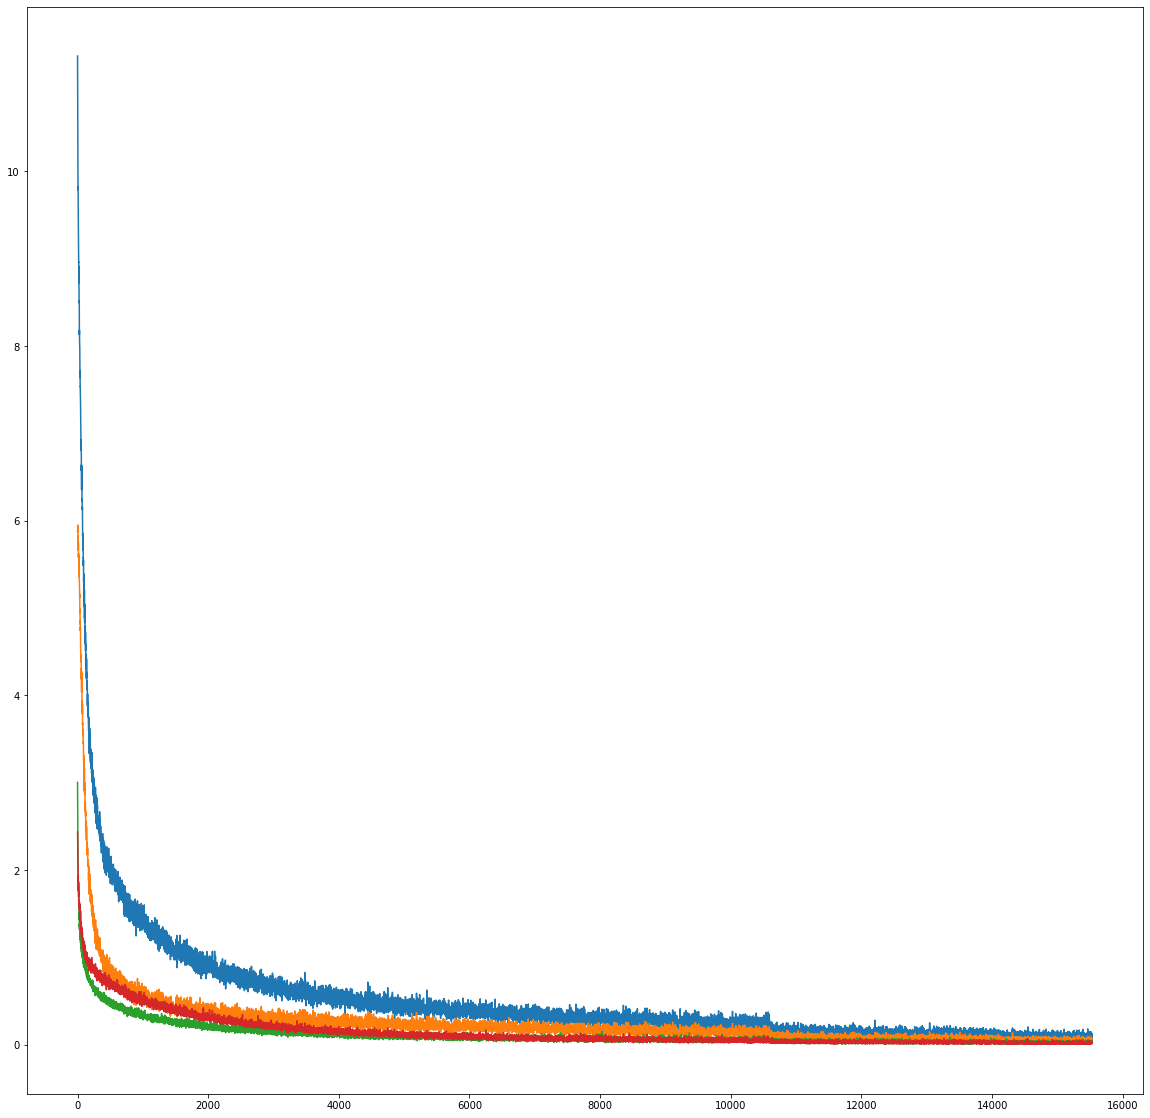

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in tr_losses])

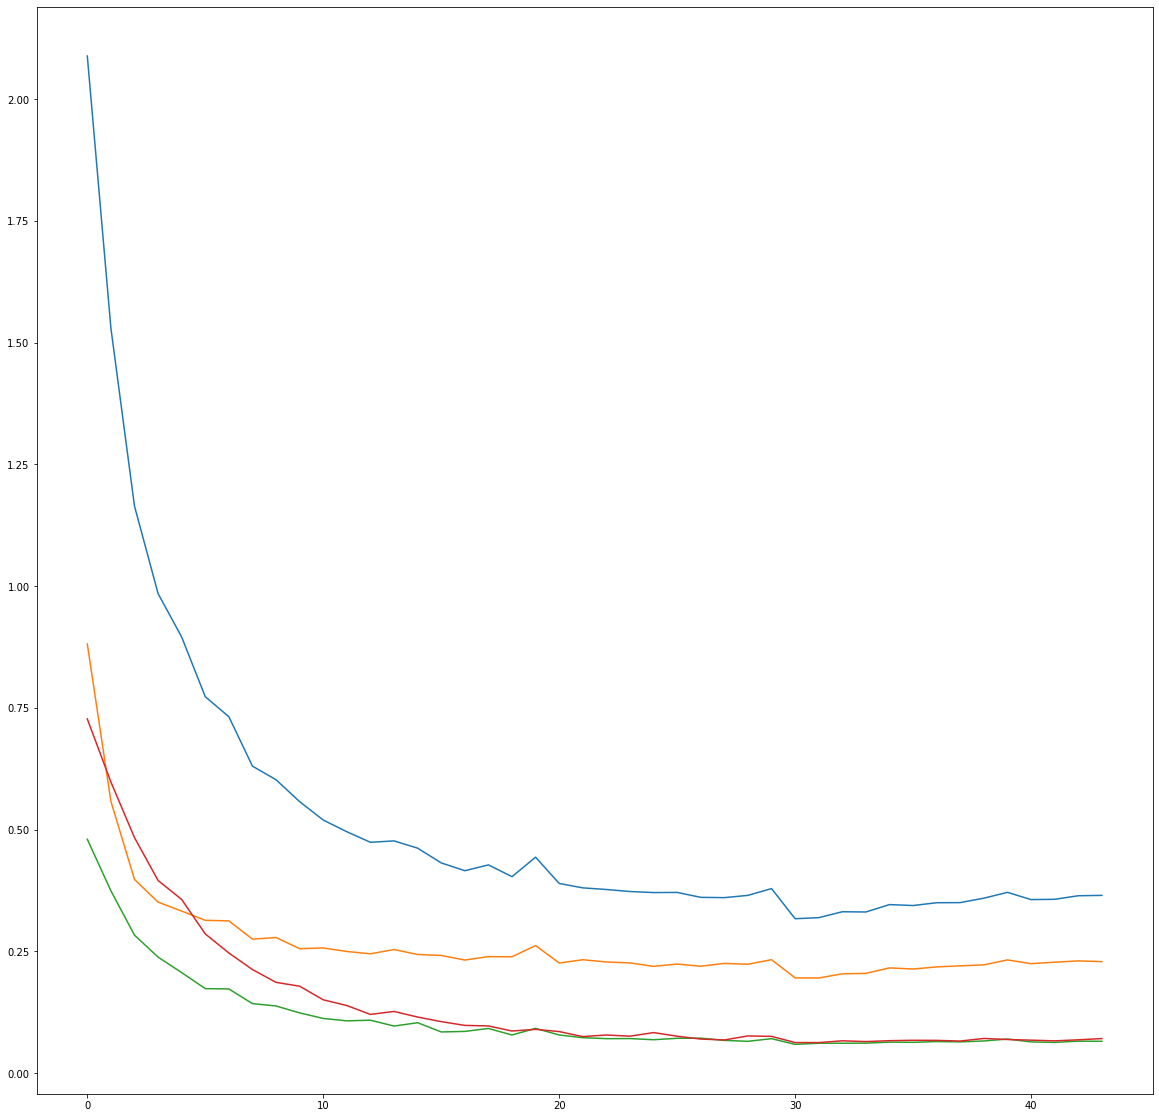

In [0]:
 plt.figure(figsize = (20, 20))
 plt.plot([t for t in va_losses])

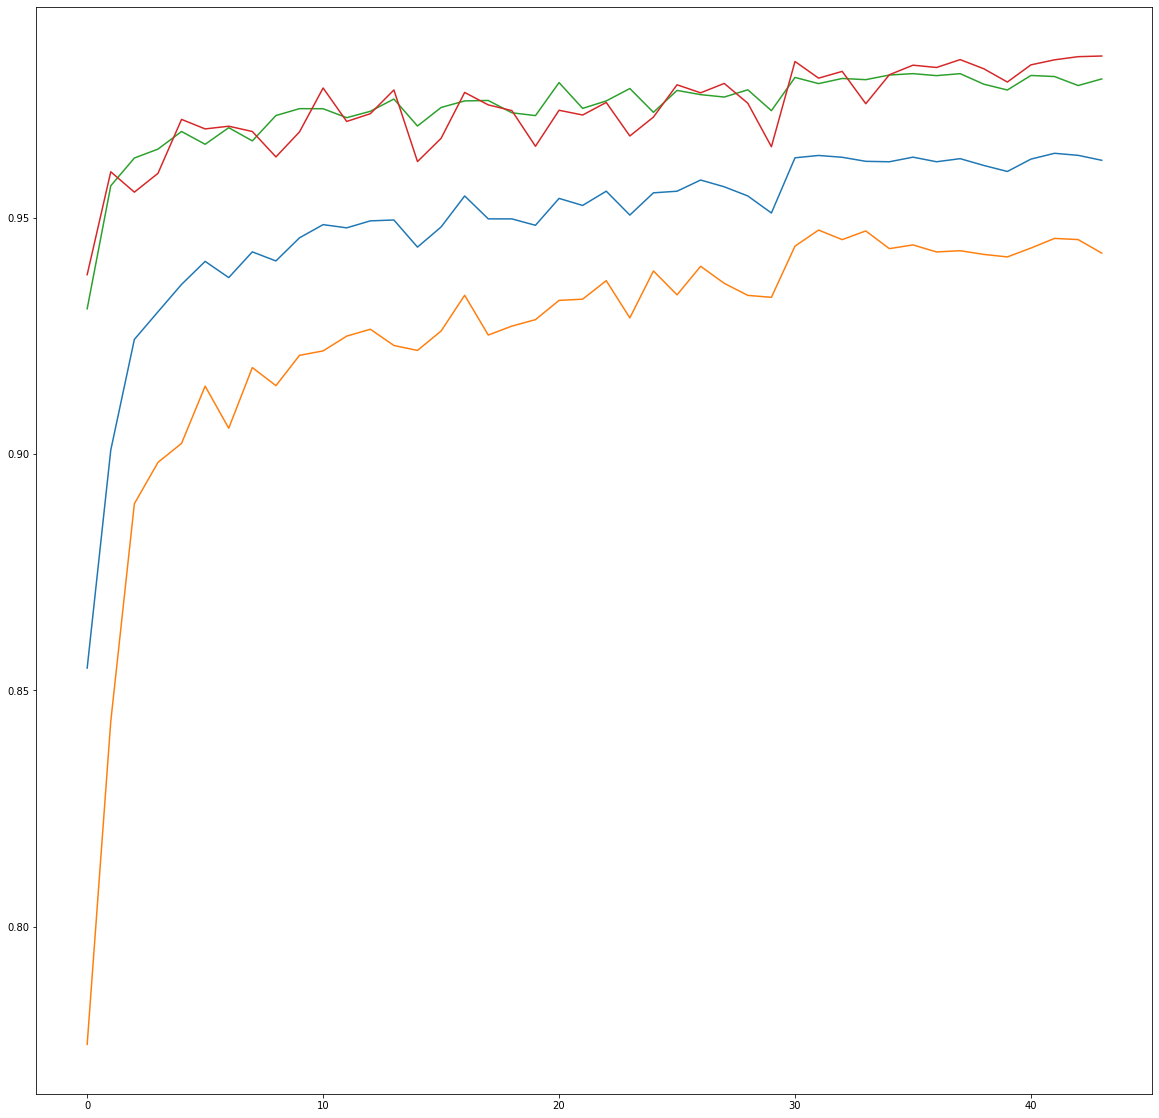

In [0]:
plt.figure(figsize = (20, 20))
plt.plot([t for t in va_scores])

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/model-gvct.pth')
torch.save(optimizer.state_dict(), 'drive/My Drive/optim-gvct.pth')

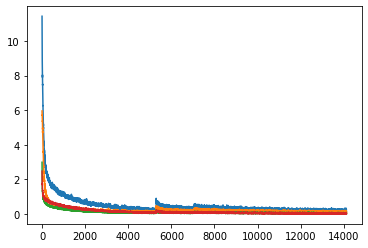

In [0]:
 plt.plot([t for t in tr_losses])

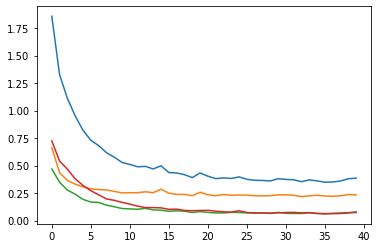

In [0]:
 plt.plot([t for t in va_losses])

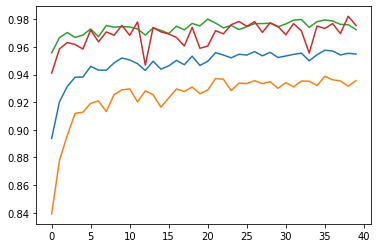

In [0]:
plt.plot([t for t in va_scores])

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/model-gvc.pth')
torch.save(optimizer.state_dict(), 'drive/My Drive/optim-gvc.pth')